# Project 3: Subreddit predictions: Classifying subreddit posts between IOTA and IOTAmarkets using NLP

## Executive Summary

### Overview

The subreddit posts dataset was pulled from two subreddits using the publically avaialable API. The subreddits selected for this project sit within the same domain and therefore have a lof of overlapping content making classification based on the text in a given post more challenging. Our goal is accuratley classify which subreddit a post belongs too by pre-processing the post text using Natural Language Processing techniques and then applying a classification model to the cleaned/processed text data. This predictive algorithm could be useful for moderators of a given subreddit who would like to flag posts that do not belong in their thread. 

### Problem Statement

This technical report steps through the workflow of building a predictive model to accuratley predict which subreddit a post belongs in. Multiple classification models (Naive-bayes Multinomial, Naive-bayes Bernoulli, Logistic Regression, Decision Tree's and Random Forests) are evaluated in order to select a production model with the least amount of error (e.g. bias) that generalizes well to the data (e.g. low variance b/w test and train scores). 

Throughout the report we'll seek to identify trends in the text data that answers relevant questions moderators of a subreddit would have wuch as which keywords appear most frequently in a given subreddit or which features/keywords provide the most predictive power in determining whether a post should be flagged for review. The goal of this analysis is to save reddit moderators time and energy, so they can apply that effort in more constructive and creative ways for their communities. 

### Contents:
- [Data Imports](#Data-Imports)
- [Data Cleaning](#Data-Cleaning)
- [EDA on features](#EDA-on-subreddits-text)
- [Model preprocessing](#Model-preprocessing)
- [Modelling](#Modelling)
- [Fine-tune top 3 models for evaluation](#Fine-tune-top-3-models-for-evaluation)
- [Further Natural Language Processing](#Further-Natural-Language-Processing)
- [Production Model Selection](#Production-Model-Selection)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)
- [Production Model Export and Save](#Production-Model-Export-and-Save)

### Data-set Overview

#### Data Dictionary

|Feature|Type|Dataset|Description|
|---|---|---|---|
|subreddit|int64|cleaned.csv|Binary classification of which subreddit a post belongs too (1 = IOTA, 0 = IOTAmarkets)|
|selftext|string|cleaned.csv|The descriptive text that is added to a post that comes just below the title of that post|
|title|string|cleaned.csv|The title of the post|

#### Provided Data

For this project, I've used the following datasets as source data for my model. This is a cleaned version of the data that was collected from both subreddits and combined into a single file:

- [Cleaned Reddit Text Data](./data/cleaned.csv)

You can see the original sources of of the data are the two subreddits found: [here](https://www.reddit.com/r/Iota/) and [here](https://www.reddit.com/r/IOTAmarkets/)

#### Primary Findings & Insights

I selected the logistic regression model as my production model given it's performance above all other models as well as it's interpretability. When analyzing text data, it is important to know which features/keywords provide more predictive power than others. A close runner up was the Random Forests algorithm but in the end I was able to optimize better for bias and variability in the logistic regression mode. 

The production regression model scored 96.3% on the training data & 92.2% on the test data.


Through exploratory analysis of the model coefficients it is clear that the features with the largest predictive power are: 
- Binance, price, buy, MIOTA, http, really, Bitcoin, just, 10, It, So, Btc, com, think, wallet, exchange, Crypto, market  


#### Conclusion & Recommendations

It would be valuable to implement this model for any r/IOTA reddit moderator who would like to implement a better flag warning system to notify them if posts in their thread are off topic (and belong on r/IOTAmarkets). In this scenario any post would be flagged if it was classified as a 0 and belonged on IOTAmarkets. The predictive model achieves >90% accuracy and can be trusted to save some time and only flag the posts that really seem off topic. 

#### Next Steps

Moving onto the next phase of this analysis would require additional time. In order to further refine the data, it would be necissary to gather more data from each subreddit, either further back in time or layering in comments as well. I would also likely fine tune and further optimize the model to minimize False Negatives (e.g. maximize Sensitivity) to ensure we are properly flagging all posts that do not belong on our page. It is preferrable to incorrectly classify a legitimate post and then review it vs. not flagging invalid posts altogether. Additionally I would compare our classifacation models performance to other powerful classification alogrithms (e.g. SVMs) to better understand the tradeoff of a black box algorithm vs. accuracy performance. 

## Module imports

In [1]:
import requests
import time
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.inspection import permutation_importance
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import WhitespaceTokenizer

%matplotlib inline

## Data Imports

API Pushift url syntax guidelines:
- Submissions - https://api.pushshift.io/reddit/search/submission?subreddit=boardgames
- Comments - https://api.pushshift.io/reddit/search/comment?subreddit=boardgames

Epoch Converter:
- Unix timestamp to date - https://www.epochconverter.com/ 

In [2]:
#Define a general API data pull function that intakes a date in Unix Timestamp and subreddit name 
#and returns list of post dictionaries  
def data_pull(date,subred): 
    url = 'https://api.pushshift.io/reddit/search/submission'
    params = {
        'subreddit':subred,
        'size':100,
        'before':date,
    }
    response = requests.get(url,params)
    
    global data
    
    if response.status_code == 200:
        data = response.json()
    else:
        print(response.status_code)
    
    posts = data['data']
    
    return posts

### IOTA Subreddit Data Pull

In [3]:
#Find initiate anchor date (e.g. date of 100th most recent post in first API batch)
url = 'https://api.pushshift.io/reddit/search/submission'
params = {
    'subreddit':'IOTA',
    'size':100,
}
response = requests.get(url,params)
data = response.json()    
posts = data['data']
anc_a = posts[99]['created_utc']
anc_a

1610966038

In [4]:
#Create list with anchor Unix timestamp date equal to the last post date poste in the first API pull batch 
#at time of writing this code (e.g 01.22.21 - 12:47pm)
list_dates_suba = [1610536647]

#Create an empty list to append new post list of dictioaries too
list_of_posts_suba = []

#For loop to iterate through the various dates within the list of dates
#Set range = 50 in order to pull 5000 posts per subreddit (50 x 100posts per api pull)
for date in range(0,50):
    #Run the data pull function
    posts = data_pull(list_dates_suba[date],'IOTA')
    
    #Pause to wait 1 second before next data pull
    time.sleep(1)
    
    #Write posts to a list
    list_of_posts_suba.append(posts)
    
    #Extract the last date
    n = len(posts)-1 
    date = posts[n]['created_utc']
    
    #Append the last date in pull
    list_dates_suba.append(date)

In [5]:
#Validate the list of dates created within for loop to iterate the API pull back in time
len(list_dates_suba)

51

In [6]:
#Validate the number of total posts in the list of lists
count = 0
tot = 0
for n in range(0,50):
    count = len(list_of_posts_suba[n])
    tot += count
    
print(tot)

5000


### IOTAmarkets Subreddit Data Pull

In [7]:
#Find initiate anchor date (e.g. date of 100th most recent post in first API batch)
url = 'https://api.pushshift.io/reddit/search/submission'
params = {
    'subreddit':'IOTAmarkets',
    'size':100,
}
response = requests.get(url,params)
data = response.json()    
posts = data['data']
anc_b = posts[99]['created_utc']
anc_b

1609803042

In [8]:
#Create list with anchor Unix timestamp date equal to the most recent date 
#at time of writing this code (e.g 01.22.21 - 12:47pm)
#Hardcode this date so dateset does not conitnue to change as posts are added throughout project
list_dates_subb = [1609587552]

#Create an empty list to append new post list of dictioaries too
list_of_posts_subb = []

#For loop to iterate through the various dates within the list of dates
#Set range = 50 in order to pull 5000 posts per subreddit (50 x 100posts per api pull)
for date in range(0,50):
    #Run the data pull function
    posts = data_pull(list_dates_subb[date],'IOTAmarkets')
    
    #Pause to wait 1 second before next data pull
    time.sleep(1)
    
    #Write posts to a list
    list_of_posts_subb.append(posts)
    
    #Extract the last date
    n = len(posts)-1 
    date = posts[n]['created_utc']
    
    #Append the last date in pull
    list_dates_subb.append(date)

In [9]:
#Validate the list of dates created within for loop to iterate the API pull back in time
len(list_dates_subb)

51

In [10]:
#Validate the number of total posts in the list of lists
count = 0
tot = 0
for n in range(0,50):
    count = len(list_of_posts_subb[n])
    tot += count
    
print(tot)

4975


## Data Cleaning 

In [11]:
#Flatten the lists
list_of_posts_suba = list(chain.from_iterable(list_of_posts_suba))
list_of_posts_subb = list(chain.from_iterable(list_of_posts_subb))

In [12]:
#
list_of_posts = list_of_posts_suba + list_of_posts_subb

In [13]:
#Validate the length of the lists
len(list_of_posts)

9975

In [14]:
df = pd.DataFrame(list_of_posts)

In [15]:
df.shape

(9975, 103)

In [16]:
df = df[['subreddit','selftext','title']]

In [17]:
#Check the distribution of data
df['subreddit'].value_counts(normalize=True)

Iota           0.501253
IOTAmarkets    0.498747
Name: subreddit, dtype: float64

In [18]:
#Check for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9975 entries, 0 to 9974
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  9975 non-null   object
 1   selftext   9965 non-null   object
 2   title      9975 non-null   object
dtypes: object(3)
memory usage: 233.9+ KB


In [19]:
df.dropna(inplace=True)

In [20]:
#Reset index.
df.reset_index(drop=True,inplace=True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9965 entries, 0 to 9964
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  9965 non-null   object
 1   selftext   9965 non-null   object
 2   title      9965 non-null   object
dtypes: object(3)
memory usage: 233.7+ KB


In [22]:
#Validate the distribution is stil fairly even
df['subreddit'].value_counts(normalize=True)

Iota           0.501254
IOTAmarkets    0.498746
Name: subreddit, dtype: float64

In [23]:
df.head()

,subreddit,selftext,title
0,Iota,**This posting was written(translated) in 'Kor...,[OWL WATCH] The first reason why I think IOTA ...
1,Iota,[removed],Firefly - Do I need it?
2,Iota,,Zebra DevTalk | Track and Trace with IOTA Bloc...
3,Iota,Can someone explain this:\n\n“An attacker coul...,Can someone explain this
4,Iota,[removed],Anything to Prepare for IOTA 1.5?


In [24]:
df.shape

(9965, 3)

## EDA on subreddits text

In [25]:
#Convert individually scrapped lists to dataframe
df_a = pd.DataFrame(list_of_posts_suba)
df_b = pd.DataFrame(list_of_posts_subb)
df_a = df_a[['subreddit','selftext','title']]
df_b = df_b[['subreddit','selftext','title']]

In [26]:
#Replicate data cleaning steps taken on main combined dataset
#Drop NAs
df_a.dropna(inplace=True)
#Drop [Removes]
df_a['selftext'] = df_a['selftext'].replace('\[removed\]','',regex=True)
df_a.reset_index(drop=True,inplace=True)
#Drop \n
df_a['selftext'] = df_a['selftext'].replace('\n',' ',regex=True)
df_a.reset_index(drop=True,inplace=True)
#Drop [deleted]
df_a['selftext'] = df_a['selftext'].replace('\[deleted\]','',regex=True)
df_a.reset_index(drop=True,inplace=True)

In [27]:
#Create a combined features columns
df_a['features'] = df_a['selftext'] + df_a['title']

In [28]:
#Count Vectorize words and exclude all stop words
cvec = CountVectorizer(max_features=25,stop_words='english')
cvec.fit(df_a['features'])
df_a_ft = cvec.transform(df_a['features'])

#Create a list of tuples of the most frequent words and their counts 
sum_a = df_a_ft.sum(axis=0)
top25 = [(word,sum_a[0,idx]) for word,idx in cvec.vocabulary_.items()]
top25 = sorted(top25,key = lambda x:x[1],reverse=True)
top25

[('iota', 5503),
 ('amp', 1458),
 ('https', 1108),
 ('wallet', 975),
 ('x200b', 831),
 ('trinity', 824),
 ('new', 747),
 ('use', 686),
 ('com', 674),
 ('오전', 612),
 ('just', 569),
 ('seed', 521),
 ('tangle', 501),
 ('like', 473),
 ('data', 426),
 ('time', 424),
 ('crypto', 418),
 ('network', 411),
 ('know', 400),
 ('project', 388),
 ('ledger', 376),
 ('community', 354),
 ('need', 342),
 ('help', 341),
 ('way', 323)]

In [29]:
df_a['subreddit'].unique()

array(['Iota'], dtype=object)

In [30]:
#Replicate data cleaning steps taken on main combined dataset
#Drop NAs
df_b.dropna(inplace=True)
#Drop [Removes]
df_b['selftext'] = df_b['selftext'].replace('\[removed\]','',regex=True)
df_b.reset_index(drop=True,inplace=True)
#Drop \n
df_b['selftext'] = df_b['selftext'].replace('\n',' ',regex=True)
df_b.reset_index(drop=True,inplace=True)
#Drop [deleted]
df_b['selftext'] = df_b['selftext'].replace('\[deleted\]','',regex=True)
df_b.reset_index(drop=True,inplace=True)

In [31]:
#Create a combined features columns
df_b['features'] = df_b['selftext'] + df_b['title']

In [32]:
#Count Vectorize words and exclude all stop words
cvec = CountVectorizer(max_features=25,stop_words='english')
cvec.fit(df_b['features'])
df_b_ft = cvec.transform(df_b['features'])

#Create a list of tuples of the most frequent words and their counts 
sum_b = df_b_ft.sum(axis=0)
top25_b = [(word,sum_b[0,idx]) for word,idx in cvec.vocabulary_.items()]
top25_b = sorted(top25_b,key = lambda x:x[1],reverse=True)
top25_b

[('iota', 6992),
 ('iotamarkets', 1370),
 ('price', 1210),
 ('com', 1017),
 ('https', 1009),
 ('new', 790),
 ('crypto', 767),
 ('daily', 762),
 ('post', 750),
 ('discussion', 726),
 ('market', 720),
 ('just', 716),
 ('amp', 706),
 ('use', 695),
 ('wallet', 687),
 ('binance', 675),
 ('topics', 645),
 ('sidebar', 638),
 ('news', 608),
 ('iri', 600),
 ('updated', 596),
 ('really', 582),
 ('like', 580),
 ('trading', 577),
 ('analysis', 574)]

In [33]:
df_b['subreddit'].unique()

array(['IOTAmarkets'], dtype=object)

/Users/noah/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50724 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/noah/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/noah/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50724 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/noah/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0, flags=flags)


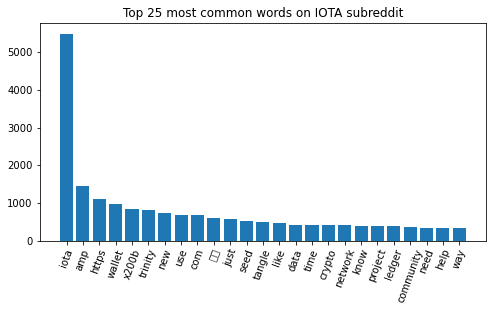

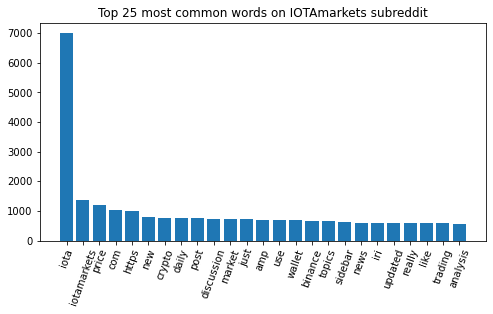

In [34]:
plt.figure(figsize=(8, 4))

plt.title('Top 25 most common words on IOTA subreddit')
plt.bar(range(len(top25)), [val[1] for val in top25], align='center')
plt.xticks(range(len(top25)), [val[0] for val in top25])
plt.xticks(rotation=70)
plt.show()

plt.figure(figsize=(8, 4))

plt.title('Top 25 most common words on IOTAmarkets subreddit')
plt.bar(range(len(top25_b)), [val[1] for val in top25_b], align='center')
plt.xticks(range(len(top25_b)), [val[0] for val in top25_b])
plt.xticks(rotation=70)
plt.show()


#### The most frequently occuring words being names/shorthand as well as special characters in the text illustrate that lematization and stemming of words will likely not be usefull on these type of interenet threads. 

## Model preprocessing

In [35]:
df.shape

(9965, 3)

In [36]:
#Replace the [removed] flag in the selftext column that occurs over 1000 times
#df['selftext'] = df['selftext'].replace('\[removed\]',' ',regex=True)
index_selftext_removed = df[df['selftext']== '[removed]'].index
df.drop(index_selftext_removed, inplace=True)

In [37]:
df.shape

(8743, 3)

In [38]:
#Validate the distribution is stil fairly even
df['subreddit'].value_counts(normalize=True)

IOTAmarkets    0.523276
Iota           0.476724
Name: subreddit, dtype: float64

In [39]:
#Replace \n characters from self text string
df['selftext'] = df['selftext'].replace('\n',' ',regex=True)
df.head()

,subreddit,selftext,title
0,Iota,**This posting was written(translated) in 'Kor...,[OWL WATCH] The first reason why I think IOTA ...
2,Iota,,Zebra DevTalk | Track and Trace with IOTA Bloc...
3,Iota,Can someone explain this: “An attacker could ...,Can someone explain this
5,Iota,,Here’s the best Google project of this year no...
7,Iota,,Senseering - Using Manufacturing Data Sovereig...


In [40]:
df['subreddit'].unique()

array(['Iota', 'IOTAmarkets'], dtype=object)

In [41]:
df['subreddit'] = df['subreddit'].map({
    'Iota':1,
    'IOTAmarkets':0
})

In [42]:
df.head()

,subreddit,selftext,title
0,1,**This posting was written(translated) in 'Kor...,[OWL WATCH] The first reason why I think IOTA ...
2,1,,Zebra DevTalk | Track and Trace with IOTA Bloc...
3,1,Can someone explain this: “An attacker could ...,Can someone explain this
5,1,,Here’s the best Google project of this year no...
7,1,,Senseering - Using Manufacturing Data Sovereig...


In [43]:
#Validate the distribution one more time
df['subreddit'].value_counts(normalize=True)

0    0.523276
1    0.476724
Name: subreddit, dtype: float64

In [44]:
#Check for any very high frequency recurring text similar to [Removed]
n=20
df['selftext'].value_counts()[:n].index.tolist()

['',
 " Welcome to r/IOTAmarkets! (also, the '#speculation' channel on Slack)  IOTA is currently traded on Bitfinex, Binance, OKEx, Coinone, CoinSpot, CoinFalcon, and [YDX](http://iotaexchange.com/#invitation).      The r/IOTAmarkets sidebar is regularly updated with helpful links to IOTA resources and community-created tools.  Remember to pay particular attention to the version numbers listed for the GUI desktop wallet, and IRI (IOTA Reference Implementation) if you run a headless full node. It is important to keep your IOTA software (GUI or IRI) updated, in order to maximize your performance and security.      Please use this daily thread to discuss topics that include, but are not limited to:  * General discussion related to the day's events  * Investment, technical analysis, trading, etc.  * Quick questions that do not require a separate post     Breaking news, or other special topics, can be submitted as a new post.  Guidelines for participation? See the rules in the r/IOTAmarkets

In [45]:
#Remove the [deleted] flag in the selftext column that occurs over 100 times
#df['selftext'] = df['selftext'].replace('\[deleted\]',' ',regex=True)

index_selftext_deleted = df[df['selftext']== '[deleted]'].index
df.drop(index_selftext_deleted, inplace=True)

In [46]:
df.shape

(8597, 3)

In [47]:
#Check for any very high frequency recurring text similar to [Removed]
n=20
df['selftext'].value_counts()[:n].index.tolist()

['',
 " Welcome to r/IOTAmarkets! (also, the '#speculation' channel on Slack)  IOTA is currently traded on Bitfinex, Binance, OKEx, Coinone, CoinSpot, CoinFalcon, and [YDX](http://iotaexchange.com/#invitation).      The r/IOTAmarkets sidebar is regularly updated with helpful links to IOTA resources and community-created tools.  Remember to pay particular attention to the version numbers listed for the GUI desktop wallet, and IRI (IOTA Reference Implementation) if you run a headless full node. It is important to keep your IOTA software (GUI or IRI) updated, in order to maximize your performance and security.      Please use this daily thread to discuss topics that include, but are not limited to:  * General discussion related to the day's events  * Investment, technical analysis, trading, etc.  * Quick questions that do not require a separate post     Breaking news, or other special topics, can be submitted as a new post.  Guidelines for participation? See the rules in the r/IOTAmarkets

### Save clean data file

In [48]:
df.to_csv('data/cleaned.csv')

### Baseline accuracy

In [49]:
df['subreddit'].value_counts(normalize=True)

0    0.520181
1    0.479819
Name: subreddit, dtype: float64

Baseline accuracy is 50.1% percent 

# Modelling 

### Split our data into `X` and `y`

In [50]:
X = df[['selftext','title']]
y = df['subreddit']

### Train/Test Split

In [51]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25, random_state = 42, stratify = y)

### Hyperparametrization for CountVectorizer

In [52]:
#Pipe for Naive Bayes - Multinomial
pipe_cv_nb = Pipeline([('cvec',CountVectorizer()),('nb',MultinomialNB())])

#Pipe for KNN
pipe_cv_knn = Pipeline([('cvec',CountVectorizer()),('knn',KNeighborsClassifier())]) 

#Pipe for lr
pipe_cv_lr = Pipeline([('cvec',CountVectorizer()),('lr',LogisticRegression())])

#Pipe for dt
pipe_cv_dt = Pipeline([('cvec',CountVectorizer()),('dt',DecisionTreeClassifier())])

#Pipe for rf
pipe_cv_rf = Pipeline([('cvec',CountVectorizer()),('rf',RandomForestClassifier())])

In [53]:
#NB/KNN/LR Pipe Parameters
pipe_params_cv = {'cvec__max_features':[1000,2500,5000],
               'cvec__stop_words':[None,'english'],
              'cvec__ngram_range':[(1,1),(1,2)],
                 'cvec__lowercase':[True,False]
                 }

#Dt Pipe Parameters
pipe_params_cv_dt = {'cvec__max_features':[1000,2500,5000],
               'cvec__stop_words':[None,'english'],
              'cvec__ngram_range':[(1,1),(1,2)],
                 'cvec__lowercase':[True,False],
                 'dt__max_depth':[3,5,7,10],
                  'dt__min_samples_split':[5,10,15,20],
                  'dt__min_samples_leaf':[2,3,4,5,6,7]
                 }
#RF Pipe Parameters
pipe_params_cv_rf = {'cvec__max_features':[1000,2500,5000],
               'cvec__stop_words':[None,'english'],
              'cvec__ngram_range':[(1,1),(1,2)],
                 'cvec__lowercase':[True,False],
                  'rf__n_estimators':[100,150,200],
                  'rf__max_depth':[None,3,5,10],
                  'rf__min_samples_split':[2,3,4,5],
                  'rf__min_samples_leaf':[2,3,4,5]
                 }

In [54]:
#Gridsearch

#Gridsearch for Naive Bayes - Multinomial
gs_cv_nb = GridSearchCV(pipe_cv_nb,param_grid=pipe_params_cv,cv=5,n_jobs=-1,verbose=2)

#Gridsearch for KNN
gs_cv_knn = GridSearchCV(pipe_cv_knn,param_grid=pipe_params_cv,cv=5,n_jobs=-1,verbose=2)

#Gridsearch for lr
gs_cv_lr = GridSearchCV(pipe_cv_lr,param_grid=pipe_params_cv,cv=5,n_jobs=-1,verbose=2)

#Gridsearch for dt
gs_cv_dt = GridSearchCV(pipe_cv_dt,param_grid=pipe_params_cv_dt,cv=5,n_jobs=-1,verbose=2)

#Gridsearch for rf
gs_cv_rf = GridSearchCV(pipe_cv_rf,param_grid=pipe_params_cv_rf,cv=5,n_jobs=-1,verbose=2)

## Fit models and Evaluate

### Naive Bayes - Multinomial

Fit the best tuned model using both the `selftext` column and the `title` column:

In [55]:
gs_cv_nb.fit(X_train['selftext'],y_train)
print(gs_cv_nb.best_score_)
print(gs_cv_nb.best_params_)

gs_cv_nb_model = gs_cv_nb.best_estimator_

print(gs_cv_nb_model.score(X_train['selftext'],y_train))
print(gs_cv_nb_model.score(X_test['selftext'],y_test))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   39.5s finished


0.5920597061600543
{'cvec__lowercase': False, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None}
0.6164107336745773
0.5841860465116279


In [56]:
gs_cv_nb.fit(X_train['title'],y_train)

print(gs_cv_nb.best_score_)
print(gs_cv_nb.best_params_)

gs_cv_nb_model = gs_cv_nb.best_estimator_

print(gs_cv_nb_model.score(X_train['title'],y_train))
print(gs_cv_nb_model.score(X_test['title'],y_test))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   10.9s finished


0.7535309506197342
{'cvec__lowercase': True, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english'}
0.8372886613928959
0.7255813953488373


### K-nearest-neighbour 

Fit the best tuned model using both the `selftext` column and the `title` column:

In [57]:
gs_cv_knn.fit(X_train['selftext'],y_train)

print(gs_cv_knn.best_score_)
print(gs_cv_knn.best_params_)

gs_cv_knn_model = gs_cv_knn.best_estimator_

print(gs_cv_knn_model.score(X_train['selftext'],y_train))
print(gs_cv_knn_model.score(X_test['selftext'],y_test))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   49.5s finished


0.5939164426482881
{'cvec__lowercase': True, 'cvec__max_features': 1000, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english'}
0.6547231270358306
0.6


In [58]:
gs_cv_knn.fit(X_train['title'],y_train)

print(gs_cv_knn.best_score_)
print(gs_cv_knn.best_params_)

gs_cv_knn_model = gs_cv_knn.best_estimator_

print(gs_cv_knn_model.score(X_train['title'],y_train))
print(gs_cv_knn_model.score(X_test['title'],y_test))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   24.4s finished


0.6516227350088104
{'cvec__lowercase': True, 'cvec__max_features': 1000, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english'}
0.7733829688227082
0.6437209302325582


### Logistic Regression

Fit the best tuned model using both the `selftext` column and the `title` column:

In [59]:
gs_cv_lr.fit(X_train['selftext'],y_train)

print(gs_cv_lr.best_score_)
print(gs_cv_lr.best_params_)

gs_cv_lr_model = gs_cv_lr.best_estimator_

print(gs_cv_lr_model.score(X_train['selftext'],y_train))
print(gs_cv_lr_model.score(X_test['selftext'],y_test))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   44.2s finished
/Users/noah/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6354870370036263
{'cvec__lowercase': False, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english'}
0.7186288196060183
0.6348837209302326


In [60]:
gs_cv_lr.fit(X_train['title'],y_train)

print(gs_cv_lr.best_score_)
print(gs_cv_lr.best_params_)

gs_cv_lr_model = gs_cv_lr.best_estimator_

print(gs_cv_lr_model.score(X_train['title'],y_train))
print(gs_cv_lr_model.score(X_test['title'],y_test))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   24.2s finished


0.7332111305561069
{'cvec__lowercase': True, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english'}
0.8883201489064682
0.7055813953488372


### Decision Trees

Fit the best tuned model using both the `selftext` column and the `title` column:

In [61]:
gs_cv_dt.fit(X_train['title'],y_train)

print(gs_cv_dt.best_score_)
print(gs_cv_dt.best_params_)

gs_cv_dt_model = gs_cv_dt.best_estimator_

print(gs_cv_dt_model.score(X_train['title'],y_train))
print(gs_cv_dt_model.score(X_test['title'],y_test))

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 9105 tasks      | 

0.6136211593627655
{'cvec__lowercase': True, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None, 'dt__max_depth': 10, 'dt__min_samples_leaf': 4, 'dt__min_samples_split': 10}
0.6230805025593299
0.6074418604651163


In [62]:
gs_cv_dt.fit(X_train['selftext'],y_train)

print(gs_cv_dt.best_score_)
print(gs_cv_dt.best_params_)

gs_cv_dt_model = gs_cv_dt.best_estimator_

print(gs_cv_dt_model.score(X_train['selftext'],y_train))
print(gs_cv_dt_model.score(X_test['selftext'],y_test))

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 27.3min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 36.9min
[Parallel(n_jobs=-1)]: Done 9105 tasks      | 

0.6075667093654717
{'cvec__lowercase': True, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'dt__max_depth': 10, 'dt__min_samples_leaf': 6, 'dt__min_samples_split': 20}
0.6216845044206608
0.5934883720930233


### Random Forests

Fit the best tuned model using both the `selftext` column and the `title` column:

In [63]:
gs_cv_rf.fit(X_train['title'],y_train)

print(gs_cv_rf.best_score_)
print(gs_cv_rf.best_params_)

gs_cv_rf_model = gs_cv_rf.best_estimator_

print(gs_cv_rf_model.score(X_train['title'],y_train))
print(gs_cv_rf_model.score(X_test['title'],y_test))

Fitting 5 folds for each of 4608 candidates, totalling 23040 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 26.5min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 39.0min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 45.1min
[Parallel(n_jobs=-1)]: Done 9105 tasks      | 

0.7412786788628887
{'cvec__lowercase': True, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
0.8444237629905382
0.718139534883721


In [64]:
gs_cv_rf.fit(X_train['selftext'],y_train)

print(gs_cv_rf.best_score_)
print(gs_cv_rf.best_params_)

gs_cv_rf_model = gs_cv_rf.best_estimator_

print(gs_cv_rf_model.score(X_train['selftext'],y_train))
print(gs_cv_rf_model.score(X_test['selftext'],y_test))

Fitting 5 folds for each of 4608 candidates, totalling 23040 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 28.4min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 35.2min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 40.5min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 46.7min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 58.5min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 68.1min
[Parallel(n_jobs=-1)]: Done 9105 tasks      | 

0.6437068576686452
{'cvec__lowercase': True, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 150}
0.7015666201333953
0.6446511627906977


Initial results show the following:
- Algorithms performing the best
  - Bayes - Multinomial 
        - 'cvec__lowercase': False, 
        - 'cvec__max_features': 5000
        - 'cvec__ngram_range': (1, 1)
        - 'cvec__stop_words': 'english'
  - Logistic Regression
        - 'cvec__lowercase': False
        - 'cvec__max_features': 5000
        - 'cvec__ngram_range': (1, 1)
        - 'cvec__stop_words': None
  - Random Forests
        - 'cvec__lowercase': True
        - 'cvec__max_features': 5000
        - 'cvec__ngram_range': (1, 2)
        - 'cvec__stop_words': None
        - 'rf__max_depth': None
        - 'rf__min_samples_leaf': 2
        - 'rf__min_samples_split': 3
        - 'rf__n_estimators': 150}
- String data performing the best
  - Title (perhaps investigate combining both data sets to get more data)
- Hyperparameters consistently performoing the best across all models
  - Max Features: 5000 (investigate increasing this number in future Pipes)
  - Lowercase: False for Bayes/Logistic, True for Random Forests
  - ngram range: (1,1) for Bayes/Logistic and (1,2) for RF
  - Stop words: English for bayes, Log/RF None
  - RF Params: Max Depth - None; Min Samples Leaf - 2; Min Samples Split - 3; n estimators - 150
- Further parameters to investigate:
  - Logreg C-Value
  - Max_df for CountVectorizer
  - TFID vectorizer

In [65]:
df.head()

,subreddit,selftext,title
0,1,**This posting was written(translated) in 'Kor...,[OWL WATCH] The first reason why I think IOTA ...
2,1,,Zebra DevTalk | Track and Trace with IOTA Bloc...
3,1,Can someone explain this: “An attacker could ...,Can someone explain this
5,1,,Here’s the best Google project of this year no...
7,1,,Senseering - Using Manufacturing Data Sovereig...


In [66]:
#Combine both string columns into 1
df['features'] = df['title'] + df['selftext']

In [67]:
df.head()

,subreddit,selftext,title,features
0,1,**This posting was written(translated) in 'Kor...,[OWL WATCH] The first reason why I think IOTA ...,[OWL WATCH] The first reason why I think IOTA ...
2,1,,Zebra DevTalk | Track and Trace with IOTA Bloc...,Zebra DevTalk | Track and Trace with IOTA Bloc...
3,1,Can someone explain this: “An attacker could ...,Can someone explain this,Can someone explain thisCan someone explain th...
5,1,,Here’s the best Google project of this year no...,Here’s the best Google project of this year no...
7,1,,Senseering - Using Manufacturing Data Sovereig...,Senseering - Using Manufacturing Data Sovereig...


### Split our data into `X` and `y`

In [68]:
X = df[['features']]
y = df['subreddit']

### Train/Test Split

In [69]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25, random_state = 42, stratify = y)

## Fine-tune top 3 models for evaluation

In [70]:
#Pipes for cvec
pipe_cv_nbm = Pipeline([('cvec',CountVectorizer()),('nbm',MultinomialNB())])
pipe_cv_nbb = Pipeline([('cvec',CountVectorizer()),('nbb',BernoulliNB())])
pipe_cv_lr = Pipeline([('cvec',CountVectorizer()),('lr',LogisticRegression())])
pipe_cv_rf = Pipeline([('cvec',CountVectorizer()),('rf',RandomForestClassifier())])

#Pipes for tvec
pipe_tv_nbm = Pipeline([('tvec',TfidfVectorizer()),('nbm',MultinomialNB())])
pipe_tv_nbb = Pipeline([('tvec',TfidfVectorizer()),('nbb',BernoulliNB())])
pipe_tv_lr = Pipeline([('tvec',TfidfVectorizer()),('lr',LogisticRegression())])
pipe_tv_rf = Pipeline([('tvec',TfidfVectorizer()),('rf',RandomForestClassifier())])

In [71]:
#NB Pipe Parameters
pipe_params_cv_nb = {'cvec__max_features':[5000,7500,10000],
               'cvec__stop_words':['english'],
              'cvec__ngram_range':[(1,1)],
                 'cvec__lowercase':[False],
                     'cvec__strip_accents':['ascii','unicode'],
                     'cvec__max_df':[0.9,0.95,0.98]
                 }

#Logreg Pipe Parameters
pipe_params_cv_lr = {'cvec__max_features':[5000,7500,10000],
               'cvec__stop_words':[None],
              'cvec__ngram_range':[(1,1)],
                 'cvec__lowercase':[False],
                     'cvec__strip_accents':['ascii','unicode'],
                     'cvec__max_df':[0.9,0.95,0.98],
                     'lr__C':[0.1,0.25,0.5]
                 }

#RF Pipe Parameters
pipe_params_cv_rf = {'cvec__max_features':[5000,10000],
               'cvec__stop_words':[None],
              'cvec__ngram_range':[(1,2)],
                 'cvec__lowercase':[True],
                     'cvec__strip_accents':['ascii','unicode'],
                     'cvec__max_df':[0.9,0.95,0.98],
                  'rf__n_estimators':[150],
                  'rf__max_depth':[None],
                  'rf__min_samples_split':[3],
                  'rf__min_samples_leaf':[2]
                 }
#NB Pipe Parameters
pipe_params_tv_nb = {'tvec__max_features':[5000,7500,10000],
               'tvec__stop_words':['english'],
              'tvec__ngram_range':[(1,1)],
                 'tvec__lowercase':[False],
                     'tvec__strip_accents':['ascii','unicode'],
                     'tvec__max_df':[0.9,0.95,0.98]
                 }

#Logreg Pipe Parameters
pipe_params_tv_lr = {'tvec__max_features':[5000,7500,10000],
               'tvec__stop_words':[None],
              'tvec__ngram_range':[(1,1)],
                 'tvec__lowercase':[False],
                     'tvec__strip_accents':['ascii','unicode'],
                     'tvec__max_df':[0.9,0.95,0.98],
                     'lr__C':[0.1,0.25,0.5]
                 }

#RF Pipe Parameters
pipe_params_tv_rf = {'tvec__max_features':[5000,10000],
               'tvec__stop_words':[None],
              'tvec__ngram_range':[(1,2)],
                 'tvec__lowercase':[True],
                     'tvec__strip_accents':['ascii','unicode'],
                     'tvec__max_df':[0.9,0.95,0.98],
                  'rf__n_estimators':[150],
                  'rf__max_depth':[None],
                  'rf__min_samples_split':[3],
                  'rf__min_samples_leaf':[2]
                 }

In [72]:
#Gridsearch CVEC

#Gridsearch for Naive Bayes - Multinomial
gs_cv_nbm = GridSearchCV(pipe_cv_nbm,param_grid=pipe_params_cv_nb,cv=5,n_jobs=-1,verbose=2)

#Gridsearch for Naive Bayes - Bernoulli
gs_cv_nbb = GridSearchCV(pipe_cv_nbb,param_grid=pipe_params_cv_nb,cv=5,n_jobs=-1,verbose=2)

#Gridsearch for lr
gs_cv_lr = GridSearchCV(pipe_cv_lr,param_grid=pipe_params_cv_lr,cv=5,n_jobs=-1,verbose=2)

#Gridsearch for rf
gs_cv_rf = GridSearchCV(pipe_cv_rf,param_grid=pipe_params_cv_rf,cv=5,n_jobs=-1,verbose=2)

#Gridsearch TVEC

#Gridsearch for Naive Bayes - Multinomial
gs_tv_nbm = GridSearchCV(pipe_tv_nbm,param_grid=pipe_params_tv_nb,cv=5,n_jobs=-1,verbose=2)

#Gridsearch for Naive Bayes - Bernoulli
gs_tv_nbb = GridSearchCV(pipe_tv_nbb,param_grid=pipe_params_tv_nb,cv=5,n_jobs=-1,verbose=2)

#Gridsearch for lr
gs_tv_lr = GridSearchCV(pipe_tv_lr,param_grid=pipe_params_tv_lr,cv=5,n_jobs=-1,verbose=2)

#Gridsearch for rf
gs_tv_rf = GridSearchCV(pipe_tv_rf,param_grid=pipe_params_tv_rf,cv=5,n_jobs=-1,verbose=2)

### Model Fit and Evaluation

In [73]:
X_train.head()

,features
4614,When was the IF gonna tell us about CFB if not...
1103,Release HORNET-0.5.0 · gohornet/hornet · GitHub
8604,Suggestion: Implement a Fiat-Gateway into the ...
7793,Iota available now on etoro.com
3479,Bad partnership concernThe IOTA foundation and...


### Naive Bayes - Multinomial
CountVectorizer: 

In [74]:
gs_cv_nbm.fit(X_train['features'],y_train)
gs_cv_nbm_model = gs_cv_nbm.best_estimator_

print('gs_cv_nbm')
print(gs_cv_nbm.best_score_)
print(gs_cv_nbm.best_params_)
print(gs_cv_nbm_model.score(X_train['features'],y_train))
print(gs_cv_nbm_model.score(X_test['features'],y_test))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   20.7s finished


gs_cv_nbm
0.7614432196101779
{'cvec__lowercase': False, 'cvec__max_df': 0.9, 'cvec__max_features': 10000, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'cvec__strip_accents': 'ascii'}
0.8341864433069645
0.7511627906976744


TfidfVectorizer:

In [75]:
gs_tv_nbm.fit(X_train['features'],y_train)
gs_tv_nbm_model = gs_tv_nbm.best_estimator_

print('gs_tv_nbm')
print(gs_tv_nbm.best_score_)
print(gs_tv_nbm.best_params_)
print(gs_tv_nbm_model.score(X_train['features'],y_train))
print(gs_tv_nbm_model.score(X_test['features'],y_test))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   19.8s finished


gs_tv_nbm
0.7642337970062726
{'tvec__lowercase': False, 'tvec__max_df': 0.9, 'tvec__max_features': 7500, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english', 'tvec__strip_accents': 'ascii'}
0.846285093842097
0.7506976744186047


### Naive Bayes - Bernoulli
CountVectorizer: 

In [76]:
gs_cv_nbb.fit(X_train['features'],y_train)
gs_cv_nbb_model = gs_cv_nbb.best_estimator_

print('gs_cv_nbb')
print(gs_cv_nbb.best_score_)
print(gs_cv_nbb.best_params_)
print(gs_cv_nbb_model.score(X_train['features'],y_train))
print(gs_cv_nbb_model.score(X_test['features'],y_test))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   19.1s finished


gs_cv_nbb
0.6781444662950067
{'cvec__lowercase': False, 'cvec__max_df': 0.9, 'cvec__max_features': 10000, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'cvec__strip_accents': 'unicode'}
0.7181634868931286
0.6669767441860465


TfidfVectorizer:

In [77]:
gs_tv_nbb.fit(X_train['features'],y_train)
gs_tv_nbb_model = gs_tv_nbb.best_estimator_

print('gs_tv_nbb')
print(gs_tv_nbb.best_score_)
print(gs_tv_nbb.best_params_)
print(gs_tv_nbb_model.score(X_train['features'],y_train))
print(gs_tv_nbb_model.score(X_test['features'],y_test))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   19.9s finished


gs_tv_nbb
0.6781444662950067
{'tvec__lowercase': False, 'tvec__max_df': 0.9, 'tvec__max_features': 10000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english', 'tvec__strip_accents': 'unicode'}
0.7181634868931286
0.6669767441860465


### Logistic Regression
CountVectorizer: 

In [78]:
gs_cv_lr.fit(X_train['features'],y_train)
gs_cv_lr_model = gs_cv_lr.best_estimator_

print('gs_cv_lr')
print(gs_cv_lr.best_score_)
print(gs_cv_lr.best_params_)
print(gs_cv_lr_model.score(X_train['features'],y_train))
print(gs_cv_lr_model.score(X_test['features'],y_test))

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  1.5min finished
/Users/noah/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


gs_cv_lr
0.7459298416535863
{'cvec__lowercase': False, 'cvec__max_df': 0.9, 'cvec__max_features': 10000, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'cvec__strip_accents': 'unicode', 'lr__C': 0.25}
0.8914223669923995
0.7390697674418605


TfidfVectorizer:

In [79]:
gs_tv_lr.fit(X_train['features'],y_train)
gs_tv_lr_model = gs_tv_lr.best_estimator_

print('gs_tv_lr')
print(gs_tv_lr.best_score_)
print(gs_tv_lr.best_params_)
print(gs_tv_lr_model.score(X_train['features'],y_train))
print(gs_tv_lr_model.score(X_test['features'],y_test))

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  1.1min finished


gs_tv_lr
0.7553932199108737
{'lr__C': 0.5, 'tvec__lowercase': False, 'tvec__max_df': 0.9, 'tvec__max_features': 7500, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None, 'tvec__strip_accents': 'unicode'}
0.8344966651155576
0.7516279069767442


### Random Forests
CountVectorizer: 

In [80]:
gs_cv_rf.fit(X_train['features'],y_train)
gs_cv_rf_model = gs_cv_rf.best_estimator_

print('gs_cv_rf')
print(gs_cv_rf.best_score_)
print(gs_cv_rf.best_params_)
print(gs_cv_rf_model.score(X_train['features'],y_train))
print(gs_cv_rf_model.score(X_test['features'],y_test))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.8min finished


gs_cv_rf
0.7491846933804824
{'cvec__lowercase': True, 'cvec__max_df': 0.98, 'cvec__max_features': 10000, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None, 'cvec__strip_accents': 'unicode', 'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 3, 'rf__n_estimators': 150}
0.8973165813556693
0.7316279069767442


TfidfVectorizer:

In [81]:
gs_tv_rf.fit(X_train['features'],y_train)
gs_tv_rf_model = gs_tv_rf.best_estimator_

print('gs_tv_rf')
print(gs_tv_rf.best_score_)
print(gs_tv_rf.best_params_)
print(gs_tv_rf_model.score(X_train['features'],y_train))
print(gs_tv_rf_model.score(X_test['features'],y_test))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.0min finished


gs_tv_rf
0.7479437819113428
{'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 3, 'rf__n_estimators': 150, 'tvec__lowercase': True, 'tvec__max_df': 0.95, 'tvec__max_features': 10000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None, 'tvec__strip_accents': 'unicode'}
0.9187218861485963
0.7348837209302326


Insights from top performing models:
  - Logistic Regression & Cvec: Train score = 95.44% | Test Score = 90.12%
      - 'cvec__lowercase': False
      - 'cvec__max_df': 0.9
      - 'cvec__max_features': 10000
      - 'cvec__ngram_range': (1, 1)
      - 'cvec__stop_words': None
      - 'cvec__strip_accents': 'unicode'
      - 'lr__C': 0.5
  - Random Forests & Tvec: Train score = 95.28% | Test Score = 89.74%
      - 'rf__max_depth': None
      - 'rf__min_samples_leaf': 2
      - 'rf__min_samples_split': 3
      - 'rf__n_estimators': 150
      - 'tvec__lowercase': True
      - 'tvec__max_df': 0.98
      - 'tvec__max_features': 5000
      - 'tvec__ngram_range': (1, 2)
      - 'tvec__stop_words': None
      - 'tvec__strip_accents': 'ascii'
      
Given variability is high, I will continue to fine tune both of these models prior to selecting a final model for production. First let's conduct further EDA on both models to better understand the features driving better predictibility.

### Logistic Regression Model EDA

In [82]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25, random_state = 42, stratify = y)

In [83]:
X_train.head()

,features
4614,When was the IF gonna tell us about CFB if not...
1103,Release HORNET-0.5.0 · gohornet/hornet · GitHub
8604,Suggestion: Implement a Fiat-Gateway into the ...
7793,Iota available now on etoro.com
3479,Bad partnership concernThe IOTA foundation and...


In [84]:
#Transformer instantiate and fit with stopwords removed
cvec = CountVectorizer(max_features=100,max_df=0.9,stop_words='english',strip_accents='unicode',lowercase = False)
cvec.fit(X_train['features'])
X_train = cvec.transform(X_train['features'])

In [85]:
#List out the most common words from my corpus

sum_train = X_train.sum(axis=0)
test_freq = [(word,sum_train[0,idx]) for word,idx in cvec.vocabulary_.items()]
test_freq = sorted(test_freq,key = lambda x:x[1],reverse=True)
test_freq

[('IOTA', 6775),
 ('amp', 1640),
 ('https', 1585),
 ('The', 1480),
 ('iota', 1324),
 ('com', 1303),
 ('IOTAmarkets', 1052),
 ('use', 967),
 ('new', 955),
 ('wallet', 953),
 ('x200B', 844),
 ('It', 839),
 ('price', 807),
 ('just', 805),
 ('IF', 765),
 ('like', 763),
 ('Iota', 734),
 ('post', 723),
 ('really', 657),
 ('sidebar', 657),
 ('time', 614),
 ('news', 609),
 ('crypto', 604),
 ('people', 598),
 ('market', 595),
 ('know', 585),
 ('think', 577),
 ('community', 558),
 ('topics', 554),
 ('updated', 552),
 ('Trinity', 547),
 ('What', 544),
 ('IRI', 526),
 ('오전', 493),
 ('security', 483),
 ('Binance', 472),
 ('node', 470),
 ('data', 465),
 ('If', 442),
 ('questions', 440),
 ('We', 431),
 ('version', 429),
 ('way', 428),
 ('important', 426),
 ('GUI', 411),
 ('Is', 406),
 ('run', 405),
 ('need', 404),
 ('buy', 401),
 ('seed', 399),
 ('order', 396),
 ('trading', 396),
 ('Please', 395),
 ('project', 395),
 ('quite', 395),
 ('Be', 387),
 ('This', 386),
 ('www', 386),
 ('How', 380),
 ('so

In [86]:
pd.options.display.max_columns = 500
X_train_df = pd.DataFrame(X_train.toarray(),columns = cvec.get_feature_names())
X_train_df

,10,2018,And,BTC,Be,Binance,Bitcoin,Bitfinex,But,Daily,GUI,How,IF,IOTA,IOTAmarkets,IRI,If,IoT,Iota,Is,It,MIOTA,Please,See,So,Thank,The,This,Trinity,We,Welcome,What,amp,buy,com,community,created,crypto,currently,data,day,discussion,don,enjoy,excellent,help,helpful,https,important,iota,just,know,like,links,make,market,need,network,new,news,node,order,participation,pay,people,performance,post,price,project,questions,quite,really,related,resources,right,rules,run,security,seed,sidebar,simple,software,special,stay,think,thread,time,tools,topics,trading,updated,use,value,version,wallet,want,way,www,x200B,오전
0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6442,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,3,0,0,2,0,0,0,2,0,3,1,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,2,0,2,0,0,0
6443,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6444,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0
6445,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [87]:
#Transform X test data
X_test = cvec.transform(X_test['features'])

In [88]:
#List out the most common words from my corpus

sum_test = X_test.sum(axis=0)
test_freq = [(word,sum_test[0,idx]) for word,idx in cvec.vocabulary_.items()]
test_freq = sorted(test_freq,key = lambda x:x[1],reverse=True)
test_freq

[('IOTA', 2245),
 ('amp', 498),
 ('https', 485),
 ('iota', 460),
 ('The', 432),
 ('com', 377),
 ('IOTAmarkets', 327),
 ('use', 321),
 ('new', 313),
 ('wallet', 288),
 ('It', 261),
 ('just', 258),
 ('x200B', 250),
 ('like', 248),
 ('IF', 233),
 ('post', 232),
 ('price', 229),
 ('Iota', 228),
 ('time', 220),
 ('know', 217),
 ('really', 211),
 ('sidebar', 209),
 ('community', 207),
 ('Trinity', 189),
 ('crypto', 188),
 ('market', 185),
 ('What', 183),
 ('think', 181),
 ('people', 174),
 ('topics', 174),
 ('updated', 172),
 ('news', 168),
 ('IRI', 166),
 ('seed', 161),
 ('project', 152),
 ('pay', 145),
 ('security', 143),
 ('How', 143),
 ('need', 142),
 ('node', 141),
 ('questions', 140),
 ('This', 137),
 ('way', 132),
 ('If', 132),
 ('order', 131),
 ('want', 130),
 ('GUI', 129),
 ('version', 128),
 ('Is', 128),
 ('quite', 128),
 ('Be', 127),
 ('Please', 126),
 ('trading', 126),
 ('We', 126),
 ('important', 124),
 ('www', 123),
 ('don', 123),
 ('data', 121),
 ('So', 121),
 ('buy', 120),
 (

In [89]:
pd.options.display.max_columns = 500
X_test_df = pd.DataFrame(X_test.toarray(),columns = cvec.get_feature_names())
X_test_df

,10,2018,And,BTC,Be,Binance,Bitcoin,Bitfinex,But,Daily,GUI,How,IF,IOTA,IOTAmarkets,IRI,If,IoT,Iota,Is,It,MIOTA,Please,See,So,Thank,The,This,Trinity,We,Welcome,What,amp,buy,com,community,created,crypto,currently,data,day,discussion,don,enjoy,excellent,help,helpful,https,important,iota,just,know,like,links,make,market,need,network,new,news,node,order,participation,pay,people,performance,post,price,project,questions,quite,really,related,resources,right,rules,run,security,seed,sidebar,simple,software,special,stay,think,thread,time,tools,topics,trading,updated,use,value,version,wallet,want,way,www,x200B,오전
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,2,0,0,0,0,0,0,0,0,9,1,1,0,0,0,0,1,0,1,1,0,1,1,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,1,1,1,1,1,1,0,1,0,1,0,1,0,0,1,1,0,1,1,0,0,1,1,0,1,2,1,1,0,1,1,1,0,2,3,3,1,1,1,1,0,1,0,1,1,0,1,3,0,1,1,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
2146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2148,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [90]:
#Estimator Instantiation and fit
logreg = LogisticRegression(C=0.5)
logreg.fit(X_train,y_train)

LogisticRegression(C=0.5)

In [91]:
print(logreg.score(X_train,y_train))
print(logreg.score(X_test,y_test))

0.6896230805025594
0.6697674418604651


In [92]:
#Checkout the most predictive features in the dataset
ft = permutation_importance(logreg,X_test_df,y_test,n_repeats=3,random_state=42,n_jobs=-1)
list_ft = [()]
for i in ft.importances_mean.argsort()[::-1]:
    if ft.importances_mean[i] -2*ft.importances_std[i]>0:
        list_ft.append((X_train_df.columns[i],ft.importances_mean[i]))
        print(f"{X_train_df.columns[i]:<8}" 
              f"{ft.importances_mean[i]:.3f}" 
              f" +/- {ft.importances_std[i]:.3f}")

price   0.025 +/- 0.004
Daily   0.016 +/- 0.001
market  0.013 +/- 0.002
MIOTA   0.012 +/- 0.002
think   0.011 +/- 0.004
2018    0.011 +/- 0.000
IOTAmarkets0.010 +/- 0.002
BTC     0.009 +/- 0.001
buy     0.008 +/- 0.002
Bitcoin 0.008 +/- 0.003
Binance 0.007 +/- 0.003
updated 0.005 +/- 0.002
How     0.005 +/- 0.001
trading 0.004 +/- 0.001
IoT     0.004 +/- 0.001
node    0.003 +/- 0.001
Bitfinex0.003 +/- 0.001
topics  0.003 +/- 0.001
discussion0.003 +/- 0.001
order   0.002 +/- 0.000
The     0.002 +/- 0.000
seed    0.002 +/- 0.001
questions0.002 +/- 0.001
use     0.002 +/- 0.001
10      0.002 +/- 0.000
excellent0.002 +/- 0.000
simple  0.002 +/- 0.000
network 0.002 +/- 0.000
Thank   0.002 +/- 0.000
오전   0.002 +/- 0.000
www     0.002 +/- 0.000
right   0.001 +/- 0.000
Welcome 0.001 +/- 0.000
helpful 0.001 +/- 0.000
version 0.001 +/- 0.000
It      0.001 +/- 0.000
links   0.001 +/- 0.000
created 0.001 +/- 0.000
wallet  0.001 +/- 0.000


In [93]:
list_ft.pop(0)

()

In [94]:
list_ft

[('price', 0.024651162790697678),
 ('Daily', 0.01550387596899224),
 ('market', 0.013178294573643426),
 ('MIOTA', 0.011782945736434089),
 ('think', 0.010852713178294579),
 ('2018', 0.01069767441860466),
 ('IOTAmarkets', 0.010232558139534905),
 ('BTC', 0.009147286821705403),
 ('buy', 0.007906976744186056),
 ('Bitcoin', 0.007751937984496138),
 ('Binance', 0.0072868217054263456),
 ('updated', 0.004961240310077534),
 ('How', 0.004806201550387579),
 ('trading', 0.004496124031007742),
 ('IoT', 0.0037209302325581137),
 ('node', 0.003410852713178314),
 ('Bitfinex', 0.002945736434108522),
 ('topics', 0.002790697674418604),
 ('discussion', 0.0026356589147286855),
 ('order', 0.002480620155038767),
 ('The', 0.0023255813953488116),
 ('seed', 0.0023255813953488116),
 ('questions', 0.002015503875968975),
 ('use', 0.002015503875968975),
 ('10', 0.002015503875968938),
 ('excellent', 0.0018604651162790198),
 ('simple', 0.0018604651162790198),
 ('network', 0.0018604651162790198),
 ('Thank', 0.001550387596

In [95]:
len(list_ft)

39

/Users/noah/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 4363 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/noah/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 4457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/noah/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 4364 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/noah/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 4453 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/noah/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 4523 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/noah/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/b

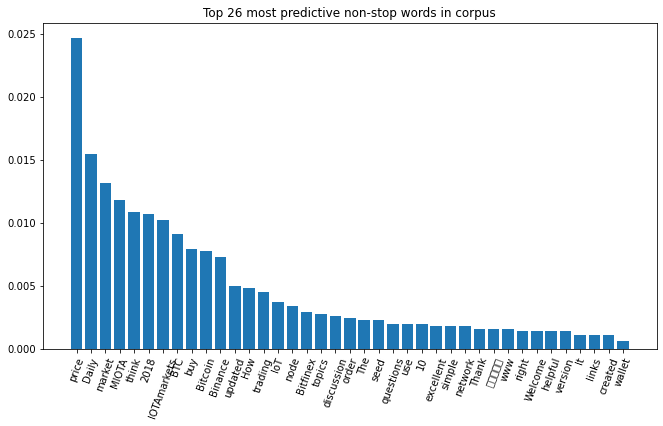

In [96]:
plt.figure(figsize=(11, 6))

plt.title('Top 26 most predictive non-stop words in corpus')
plt.bar(range(len(list_ft)), [val[1] for val in list_ft], align='center')
plt.xticks(range(len(list_ft)), [val[0] for val in list_ft])
plt.xticks(rotation=70)
plt.show()

### Random Forests Model EDA

In [97]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25, random_state = 42, stratify = y)

In [98]:
X_train.head()

,features
4614,When was the IF gonna tell us about CFB if not...
1103,Release HORNET-0.5.0 · gohornet/hornet · GitHub
8604,Suggestion: Implement a Fiat-Gateway into the ...
7793,Iota available now on etoro.com
3479,Bad partnership concernThe IOTA foundation and...


In [99]:
#Transformer instantiate and fit with stopwords included
tvec = TfidfVectorizer(max_features=100,max_df=0.98,stop_words='english',strip_accents='ascii',
                       ngram_range=(1,2),lowercase=True)
cvec.fit(X_train['features'])
X_train = cvec.transform(X_train['features'])

In [100]:
#List out the most common words from my corpus

sum_train = X_train.sum(axis=0)
test_freq = [(word,sum_train[0,idx]) for word,idx in cvec.vocabulary_.items()]
test_freq = sorted(test_freq,key = lambda x:x[1],reverse=True)
test_freq

[('IOTA', 6775),
 ('amp', 1640),
 ('https', 1585),
 ('The', 1480),
 ('iota', 1324),
 ('com', 1303),
 ('IOTAmarkets', 1052),
 ('use', 967),
 ('new', 955),
 ('wallet', 953),
 ('x200B', 844),
 ('It', 839),
 ('price', 807),
 ('just', 805),
 ('IF', 765),
 ('like', 763),
 ('Iota', 734),
 ('post', 723),
 ('really', 657),
 ('sidebar', 657),
 ('time', 614),
 ('news', 609),
 ('crypto', 604),
 ('people', 598),
 ('market', 595),
 ('know', 585),
 ('think', 577),
 ('community', 558),
 ('topics', 554),
 ('updated', 552),
 ('Trinity', 547),
 ('What', 544),
 ('IRI', 526),
 ('오전', 493),
 ('security', 483),
 ('Binance', 472),
 ('node', 470),
 ('data', 465),
 ('If', 442),
 ('questions', 440),
 ('We', 431),
 ('version', 429),
 ('way', 428),
 ('important', 426),
 ('GUI', 411),
 ('Is', 406),
 ('run', 405),
 ('need', 404),
 ('buy', 401),
 ('seed', 399),
 ('order', 396),
 ('trading', 396),
 ('Please', 395),
 ('project', 395),
 ('quite', 395),
 ('Be', 387),
 ('This', 386),
 ('www', 386),
 ('How', 380),
 ('so

In [101]:
pd.options.display.max_columns = 500
X_train_df = pd.DataFrame(X_train.toarray(),columns = cvec.get_feature_names())
X_train_df

,10,2018,And,BTC,Be,Binance,Bitcoin,Bitfinex,But,Daily,GUI,How,IF,IOTA,IOTAmarkets,IRI,If,IoT,Iota,Is,It,MIOTA,Please,See,So,Thank,The,This,Trinity,We,Welcome,What,amp,buy,com,community,created,crypto,currently,data,day,discussion,don,enjoy,excellent,help,helpful,https,important,iota,just,know,like,links,make,market,need,network,new,news,node,order,participation,pay,people,performance,post,price,project,questions,quite,really,related,resources,right,rules,run,security,seed,sidebar,simple,software,special,stay,think,thread,time,tools,topics,trading,updated,use,value,version,wallet,want,way,www,x200B,오전
0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6442,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,3,0,0,2,0,0,0,2,0,3,1,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,2,0,2,0,0,0
6443,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6444,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0
6445,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [102]:
#Transform X test data
X_test = cvec.transform(X_test['features'])

In [103]:
#List out the most common words from my corpus

sum_test = X_test.sum(axis=0)
test_freq = [(word,sum_test[0,idx]) for word,idx in cvec.vocabulary_.items()]
test_freq = sorted(test_freq,key = lambda x:x[1],reverse=True)
test_freq

[('IOTA', 2245),
 ('amp', 498),
 ('https', 485),
 ('iota', 460),
 ('The', 432),
 ('com', 377),
 ('IOTAmarkets', 327),
 ('use', 321),
 ('new', 313),
 ('wallet', 288),
 ('It', 261),
 ('just', 258),
 ('x200B', 250),
 ('like', 248),
 ('IF', 233),
 ('post', 232),
 ('price', 229),
 ('Iota', 228),
 ('time', 220),
 ('know', 217),
 ('really', 211),
 ('sidebar', 209),
 ('community', 207),
 ('Trinity', 189),
 ('crypto', 188),
 ('market', 185),
 ('What', 183),
 ('think', 181),
 ('people', 174),
 ('topics', 174),
 ('updated', 172),
 ('news', 168),
 ('IRI', 166),
 ('seed', 161),
 ('project', 152),
 ('pay', 145),
 ('security', 143),
 ('How', 143),
 ('need', 142),
 ('node', 141),
 ('questions', 140),
 ('This', 137),
 ('way', 132),
 ('If', 132),
 ('order', 131),
 ('want', 130),
 ('GUI', 129),
 ('version', 128),
 ('Is', 128),
 ('quite', 128),
 ('Be', 127),
 ('Please', 126),
 ('trading', 126),
 ('We', 126),
 ('important', 124),
 ('www', 123),
 ('don', 123),
 ('data', 121),
 ('So', 121),
 ('buy', 120),
 (

In [104]:
pd.options.display.max_columns = 500
X_test_df = pd.DataFrame(X_test.toarray(),columns = cvec.get_feature_names())
X_test_df

,10,2018,And,BTC,Be,Binance,Bitcoin,Bitfinex,But,Daily,GUI,How,IF,IOTA,IOTAmarkets,IRI,If,IoT,Iota,Is,It,MIOTA,Please,See,So,Thank,The,This,Trinity,We,Welcome,What,amp,buy,com,community,created,crypto,currently,data,day,discussion,don,enjoy,excellent,help,helpful,https,important,iota,just,know,like,links,make,market,need,network,new,news,node,order,participation,pay,people,performance,post,price,project,questions,quite,really,related,resources,right,rules,run,security,seed,sidebar,simple,software,special,stay,think,thread,time,tools,topics,trading,updated,use,value,version,wallet,want,way,www,x200B,오전
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,2,0,0,0,0,0,0,0,0,9,1,1,0,0,0,0,1,0,1,1,0,1,1,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,1,1,1,1,1,1,0,1,0,1,0,1,0,0,1,1,0,1,1,0,0,1,1,0,1,2,1,1,0,1,1,1,0,2,3,3,1,1,1,1,0,1,0,1,1,0,1,3,0,1,1,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
2146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2148,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [105]:
#Estimator Instantiation and fit
rf = RandomForestClassifier(max_depth=None,min_samples_leaf=2,min_samples_split=3,n_estimators=150)
rf.fit(X_train,y_train)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=3,
                       n_estimators=150)

In [106]:
#Checkout the most predictive features in the dataset
ft = permutation_importance(rf,X_test_df,y_test,n_repeats=3,random_state=42,n_jobs=-1)
list_ft = [()]
for i in ft.importances_mean.argsort()[::-1]:
    if ft.importances_mean[i] -2*ft.importances_std[i]>0:
        list_ft.append((X_train_df.columns[i],ft.importances_mean[i]))
        print(f"{X_train_df.columns[i]:<8}" 
              f"{ft.importances_mean[i]:.3f}" 
              f" +/- {ft.importances_std[i]:.3f}")

price   0.022 +/- 0.002
Daily   0.016 +/- 0.002
MIOTA   0.012 +/- 0.003
market  0.012 +/- 0.001
2018    0.012 +/- 0.001
think   0.012 +/- 0.003
Bitcoin 0.011 +/- 0.002
Binance 0.009 +/- 0.002
BTC     0.009 +/- 0.001
IOTA    0.007 +/- 0.003
buy     0.007 +/- 0.002
How     0.006 +/- 0.002
order   0.006 +/- 0.000
crypto  0.005 +/- 0.001
Bitfinex0.005 +/- 0.001
IOTAmarkets0.005 +/- 0.002
community0.005 +/- 0.001
people  0.005 +/- 0.002
10      0.004 +/- 0.001
www     0.004 +/- 0.001
wallet  0.004 +/- 0.001
seed    0.003 +/- 0.000
updated 0.003 +/- 0.001
Thank   0.003 +/- 0.001
If      0.002 +/- 0.001
Trinity 0.002 +/- 0.001
data    0.002 +/- 0.000
run     0.002 +/- 0.001


In [107]:
list_ft.pop(0)

()

In [108]:
list_ft

[('price', 0.021705426356589192),
 ('Daily', 0.01596899224806203),
 ('MIOTA', 0.011937984496124043),
 ('market', 0.011937984496124043),
 ('2018', 0.011782945736434125),
 ('think', 0.011627906976744207),
 ('Bitcoin', 0.010542635658914742),
 ('Binance', 0.009457364341085314),
 ('BTC', 0.00852713178294573),
 ('IOTA', 0.007131782945736427),
 ('buy', 0.006821705426356591),
 ('How', 0.006201550387596917),
 ('order', 0.006201550387596917),
 ('crypto', 0.005271317829457371),
 ('Bitfinex', 0.005116279069767415),
 ('IOTAmarkets', 0.005116279069767415),
 ('community', 0.004806201550387579),
 ('people', 0.0046511627906976605),
 ('10', 0.004496124031007742),
 ('www', 0.0041860465116279055),
 ('wallet', 0.003875968992248069),
 ('seed', 0.003410852713178314),
 ('updated', 0.002945736434108522),
 ('Thank', 0.0026356589147286855),
 ('If', 0.0021705426356589306),
 ('Trinity', 0.002015503875968975),
 ('data', 0.002015503875968975),
 ('run', 0.0017054263565891385)]

In [109]:
len(list_ft)

28

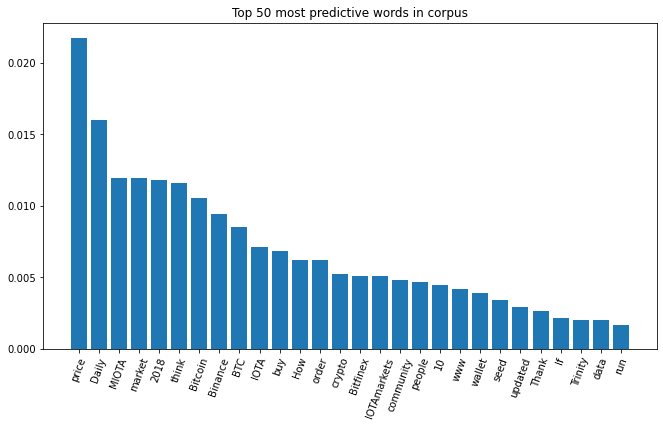

In [110]:
plt.figure(figsize=(11, 6))

plt.title('Top 50 most predictive words in corpus')
plt.bar(range(len(list_ft)), [val[1] for val in list_ft], align='center')
plt.xticks(range(len(list_ft)), [val[0] for val in list_ft])
plt.xticks(rotation=70)
plt.show()

### Insights:

The predictive keywords across both models have a lot of overlap. The RandomForests model performs best with  TfidfVectorizer whereas the LogisitcRegression model performs best with CountVecotrizer. Both of these transfromers have different tokenized features due to varying optimial parameters and transformers. These variances are called out in previous sections (e.g. lowercase, encording, etc). 

- As seen above the most predictive keywords in the logistic regression model are:   
    - Binance, price,buy,MIOTA,http,really,Bitcoin,just,10,It,So,Btc,com,think,wallet,exchange,Crypto,market

- As seen above the most predictive keywords in the random forest model are:   
    - IOTA, price, binance, buy, think, Iota,market,iota,10,Bitcoin,https,MIOTA,IoT,people,What
    
    
Given how highly both are performing with very different tokenized features, I will continue with both models and continue to hyper-parametrize the models until I can acheive the best bias-variance tradeoff. 

The amount of importance given to uppercase/lowercase variants on the same word suggests that some title words or words at the beginning of setences are important. In the next section I would also like to validate whether this is true for any features/words at the end of sentences that have been excluded up until now (e.g. have not removed punctuation)

## Further Natural Language Processing

Inspect whether further NLP methods such as regex character removal, lemmatization and stemming affect model performance amongst the top performing models.

### Regex character removal

In [111]:
#Create a new column with only words and spaces
df['letters'] = df['features'].str.replace('[^\w\s\d]','')

In [112]:
df.head()

,subreddit,selftext,title,features,letters
0,1,**This posting was written(translated) in 'Kor...,[OWL WATCH] The first reason why I think IOTA ...,[OWL WATCH] The first reason why I think IOTA ...,OWL WATCH The first reason why I think IOTA wi...
2,1,,Zebra DevTalk | Track and Trace with IOTA Bloc...,Zebra DevTalk | Track and Trace with IOTA Bloc...,Zebra DevTalk Track and Trace with IOTA Block...
3,1,Can someone explain this: “An attacker could ...,Can someone explain this,Can someone explain thisCan someone explain th...,Can someone explain thisCan someone explain th...
5,1,,Here’s the best Google project of this year no...,Here’s the best Google project of this year no...,Heres the best Google project of this year not...
7,1,,Senseering - Using Manufacturing Data Sovereig...,Senseering - Using Manufacturing Data Sovereig...,Senseering Using Manufacturing Data Sovereign...


In [113]:
X = df[['letters']]
y = df['subreddit']

In [114]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25, random_state = 42, stratify = y)

In [115]:
#Transformer Instantiation and fit
cvec = CountVectorizer(max_features=10000,max_df=0.9,stop_words=None,strip_accents='unicode',
                       ngram_range=(1,1),lowercase = False)

cvec.fit(X_train['letters'])
X_train=cvec.transform(X_train['letters'])
X_test = cvec.transform(X_test['letters'])

#Estimator Instantiation and fit
logreg = LogisticRegression(C=0.5,max_iter=200)
logreg.fit(X_train,y_train)

#Display train and test scores
print(logreg.score(X_train,y_train))
print(logreg.score(X_test,y_test))

0.9136032263068093
0.7283720930232558


Scores from original model prior to cleaning out special characters:

- 0.9544201135442011
- 0.9012645914396887

In [116]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25, random_state = 42, stratify = y)

In [117]:
#Transformer Instantiation and fit
tvec = TfidfVectorizer(max_features=5000,max_df=0.98,stop_words=None,strip_accents='ascii',
                       ngram_range=(1,2),lowercase = True)

tvec.fit(X_train['letters'])
X_train=tvec.transform(X_train['letters'])
X_test = tvec.transform(X_test['letters'])

#Estimator Instantiation and fit
rf = RandomForestClassifier(max_depth=None,min_samples_leaf=2,min_samples_split=3,n_estimators=150)
rf.fit(X_train,y_train)

#Display train and test scores
print(rf.score(X_train,y_train))
print(rf.score(X_test,y_test))

0.9156196680626648
0.7306976744186047


Scores from original model prior to cleaning out special characters:

- 0.9527980535279805
- 0.8973735408560312

#### Therefore the original data including special characters yields better scores than the alphanumeric only text in both algorithms

### Lemmatization

In [118]:
#Instantiate tokenizer
w_tokenizer = WhitespaceTokenizer()

#Instantiate Lemmatizer
lemmatizer = WordNetLemmatizer()

In [119]:
def lemmatize_text(text):
    lemm_text = [lemmatizer.lemmatize(word) for word in w_tokenizer.tokenize(text)]
    return (" ".join(lemm_text))

In [120]:
df['letters']

0       OWL WATCH The first reason why I think IOTA wi...
2       Zebra DevTalk  Track and Trace with IOTA Block...
3       Can someone explain thisCan someone explain th...
5       Heres the best Google project of this year not...
7       Senseering  Using Manufacturing Data Sovereign...
                              ...                        
9958    Have we found a bottomFor IOTA amp BTC Your th...
9959              Todays discussion with IOTA amp Fujitsu
9960    How will IOTA being added to BitIndia affect i...
9962            The Good old days  the first ever 1 party
9963    What will it take for IOTA to disconnect from ...
Name: letters, Length: 8597, dtype: object

In [121]:
#Lemmatize letters columns
df['lemm'] = df['letters'].apply(lemmatize_text)

In [122]:
df['lemm']

0       OWL WATCH The first reason why I think IOTA wi...
2       Zebra DevTalk Track and Trace with IOTA Blockc...
3       Can someone explain thisCan someone explain th...
5       Heres the best Google project of this year not...
7       Senseering Using Manufacturing Data Sovereignl...
                              ...                        
9958    Have we found a bottomFor IOTA amp BTC Your th...
9959              Todays discussion with IOTA amp Fujitsu
9960    How will IOTA being added to BitIndia affect i...
9962              The Good old day the first ever 1 party
9963    What will it take for IOTA to disconnect from ...
Name: lemm, Length: 8597, dtype: object

### Evaluate updated text data in models

In [123]:
X = df[['lemm']]
y = df['subreddit']

In [124]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25, random_state = 42, stratify = y)

In [125]:
#Transformer Instantiation and fit
cvec = CountVectorizer(max_features=10000,max_df=0.9,stop_words=None,strip_accents='unicode',
                       ngram_range=(1,1),lowercase = False)

cvec.fit(X_train['lemm'])
X_train=cvec.transform(X_train['lemm'])
X_test = cvec.transform(X_test['lemm'])

#Estimator Instantiation and fit
logreg = LogisticRegression(C=0.5,max_iter=200)
logreg.fit(X_train,y_train)

#Display train and test scores
print(logreg.score(X_train,y_train))
print(logreg.score(X_test,y_test))

0.9142236699239956
0.7316279069767442


Scores from original model prior to lemmatizing:

- 0.9544201135442011
- 0.9012645914396887

In [126]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25, random_state = 42, stratify = y)

In [127]:
#Transformer Instantiation and fit
tvec = TfidfVectorizer(max_features=5000,max_df=0.98,stop_words=None,strip_accents='ascii',
                       ngram_range=(1,2),lowercase = True)

tvec.fit(X_train['lemm'])
X_train=tvec.transform(X_train['lemm'])
X_test = tvec.transform(X_test['lemm'])

#Estimator Instantiation and fit
rf = RandomForestClassifier(max_depth=None,min_samples_leaf=2,min_samples_split=3,n_estimators=150)
rf.fit(X_train,y_train)

#Display train and test scores
print(rf.score(X_train,y_train))
print(rf.score(X_test,y_test))

0.9176361098185203
0.7344186046511628


Scores from original model prior to cleaning out special characters:

- 0.9527980535279805
- 0.8973735408560312

#### Lemmatizing the text does not improve prediction accuract in this case

### Stemming

In [128]:
#Instantiate tokenizer
w_tokenizer = WhitespaceTokenizer()

#Instantiate Stemmer
p_stemmer = PorterStemmer()

In [129]:
def stem_text(text):
    stem_text = [p_stemmer.stem(word) for word in w_tokenizer.tokenize(text)]
    return (" ".join(stem_text))

In [130]:
df['letters']

0       OWL WATCH The first reason why I think IOTA wi...
2       Zebra DevTalk  Track and Trace with IOTA Block...
3       Can someone explain thisCan someone explain th...
5       Heres the best Google project of this year not...
7       Senseering  Using Manufacturing Data Sovereign...
                              ...                        
9958    Have we found a bottomFor IOTA amp BTC Your th...
9959              Todays discussion with IOTA amp Fujitsu
9960    How will IOTA being added to BitIndia affect i...
9962            The Good old days  the first ever 1 party
9963    What will it take for IOTA to disconnect from ...
Name: letters, Length: 8597, dtype: object

In [131]:
#Lemmatize letters columns
df['stem'] = df['letters'].apply(stem_text)

In [132]:
df['stem']

0       owl watch the first reason whi I think iota wi...
2       zebra devtalk track and trace with iota blockc...
3       can someon explain thiscan someon explain thi ...
5       here the best googl project of thi year not to...
7       senseer use manufactur data sovereignli with t...
                              ...                        
9958    have we found a bottomfor iota amp btc your th...
9959                  today discuss with iota amp fujitsu
9960    how will iota be ad to bitindia affect it pric...
9962              the good old day the first ever 1 parti
9963    what will it take for iota to disconnect from ...
Name: stem, Length: 8597, dtype: object

### Evaluate updated text data in models

In [133]:
X = df[['stem']]
y = df['subreddit']

In [134]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25, random_state = 42, stratify = y)

In [135]:
#Transformer Instantiation and fit
cvec = CountVectorizer(max_features=10000,max_df=0.9,stop_words=None,strip_accents='unicode',
                       ngram_range=(1,1),lowercase = False)

cvec.fit(X_train['stem'])
X_train=cvec.transform(X_train['stem'])
X_test = cvec.transform(X_test['stem'])

#Estimator Instantiation and fit
logreg = LogisticRegression(C=0.5,max_iter=200)
logreg.fit(X_train,y_train)

#Display train and test scores
print(logreg.score(X_train,y_train))
print(logreg.score(X_test,y_test))

0.8957654723127035
0.7423255813953489


Scores from original model prior to stemming:

- 0.9544201135442011
- 0.9012645914396887

In [136]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25, random_state = 42, stratify = y)

In [137]:
#Transformer Instantiation and fit
tvec = TfidfVectorizer(max_features=5000,max_df=0.98,stop_words=None,strip_accents='ascii',
                       ngram_range=(1,2),lowercase = True)

tvec.fit(X_train['stem'])
X_train=tvec.transform(X_train['stem'])
X_test = tvec.transform(X_test['stem'])

#Estimator Instantiation and fit
rf = RandomForestClassifier(max_depth=None,min_samples_leaf=2,min_samples_split=3,n_estimators=150)
rf.fit(X_train,y_train)

#Display train and test scores
print(rf.score(X_train,y_train))
print(rf.score(X_test,y_test))

0.9165503334884443
0.746046511627907


Scores from original model prior to stemming:

- 0.9527980535279805
- 0.8973735408560312

# Production Model Selection

In [138]:
X = df[['features']]
y = df['subreddit']

In [139]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25, random_state = 42, stratify = y)

In [140]:
#Logistic Regression
pipe_cv_lr = Pipeline([('cvec',CountVectorizer()),('lr',LogisticRegression())])

#Random Forests
pipe_tv_rf = Pipeline([('tvec',TfidfVectorizer()),('rf',RandomForestClassifier())])

In [141]:
#Logistic Regression parameters
pipe_params_lr = {'cvec__max_features':[5000,10000,12000],
               'cvec__stop_words':[None],
              'cvec__ngram_range':[(1,1)],
                 'cvec__lowercase':[False],
                     'cvec__strip_accents':['unicode'],
                     'cvec__max_df':[0.7,0.8,0.9],
                     'lr__C':[0.5,0.75,0.1]
                 }
#Random Forests parameters
pipe_params_rf = {'tvec__max_features':[2500,5000,7500],
               'tvec__stop_words':[None],
              'tvec__ngram_range':[(1,2)],
                 'tvec__lowercase':[True],
                     'tvec__strip_accents':['ascii'],
                     'tvec__max_df':[0.98,0.99,1],
                  'rf__n_estimators':[150],
                  'rf__max_depth':[None],
                  'rf__min_samples_split':[3],
                  'rf__min_samples_leaf':[2]
                 }

In [142]:
#Gridsearch for lr
gs_lr = GridSearchCV(pipe_cv_lr,param_grid=pipe_params_lr,cv=5,n_jobs=-1,verbose=2)

#Gridsearch for rf
gs_rf = GridSearchCV(pipe_tv_rf,param_grid=pipe_params_rf,cv=5,n_jobs=-1,verbose=2)

In [143]:
#Fit and Modelling Logistic Regression
gs_lr.fit(X_train['features'],y_train)
gs_lr_model = gs_lr.best_estimator_

print('Logistic Regression:')
print(gs_lr.best_score_)
print(gs_lr.best_params_)
print(gs_lr_model.score(X_train['features'],y_train))
print(gs_lr_model.score(X_test['features'],y_test))

#Fit and Modelling Random Forests
gs_rf.fit(X_train['features'],y_train)
gs_rf_model = gs_rf.best_estimator_

print('Random Forests:')
print(gs_rf.best_score_)
print(gs_rf.best_params_)
print(gs_rf_model.score(X_train['features'],y_train))
print(gs_rf_model.score(X_test['features'],y_test))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   52.1s finished
/Users/noah/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression:
0.7456206060824748
{'cvec__lowercase': False, 'cvec__max_df': 0.7, 'cvec__max_features': 12000, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'cvec__strip_accents': 'unicode', 'lr__C': 0.1}
0.8607104079416783
0.7404651162790697
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.2min finished


Random Forests:
0.743757855678039
{'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 3, 'rf__n_estimators': 150, 'tvec__lowercase': True, 'tvec__max_df': 0.98, 'tvec__max_features': 5000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None, 'tvec__strip_accents': 'ascii'}
0.9239956568946797
0.7320930232558139


### Select Logistic Regression Model for final production model

In [144]:
X = df[['features']]
y = df['subreddit']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25, random_state = 42, stratify = y)

#Logistic Regression
pipe_cv_lr = Pipeline([('cvec',CountVectorizer()),('lr',LogisticRegression())])

#Logistic Regression parameters
pipe_params_lr = {'cvec__max_features':[12000,None],
               'cvec__stop_words':[None],
              'cvec__ngram_range':[(1,1)],
                 'cvec__lowercase':[False],
                     'cvec__strip_accents':['unicode',None],
                     'cvec__max_df':[0.5,0.7,0.9],
                     'lr__C':[0.5,0.75,0.1],
                  'lr__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                  'lr__warm_start':[True,False]
                 }
#Gridsearch for lr
gs_lr = GridSearchCV(pipe_cv_lr,param_grid=pipe_params_lr,cv=5,n_jobs=-1,verbose=2)

#Fit and Modelling Logistic Regression
gs_lr.fit(X_train['features'],y_train)
gs_lr_model = gs_lr.best_estimator_

print('Logistic Regression:')
print(gs_lr.best_score_)
print(gs_lr.best_params_)
print(gs_lr_model.score(X_train['features'],y_train))
print(gs_lr_model.score(X_test['features'],y_test))

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 11.6min finished


Logistic Regression:
0.7488776228192037
{'cvec__lowercase': False, 'cvec__max_df': 0.5, 'cvec__max_features': None, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'cvec__strip_accents': 'unicode', 'lr__C': 0.1, 'lr__solver': 'liblinear', 'lr__warm_start': True}
0.8697068403908795
0.738139534883721


In [145]:
#Logistic Regression parameters
pipe_params_lr = {'cvec__max_features':[None],
               'cvec__stop_words':[None],
              'cvec__ngram_range':[(1,1)],
                 'cvec__lowercase':[False],
                     'cvec__strip_accents':['unicode'],
                     'cvec__max_df':[0.1,0.3,0.5],
                     'lr__C':[0.75,0.85,0.95],
                  'lr__solver':['newton-cg'],
                  'lr__warm_start':[True]
                 }
#Gridsearch for lr
gs_lr = GridSearchCV(pipe_cv_lr,param_grid=pipe_params_lr,cv=5,n_jobs=-1,verbose=2)

#Fit and Modelling Logistic Regression
gs_lr.fit(X_train['features'],y_train)
gs_lr_model = gs_lr.best_estimator_

print('Logistic Regression:')
print(gs_lr.best_score_)
print(gs_lr.best_params_)
print(gs_lr_model.score(X_train['features'],y_train))
print(gs_lr_model.score(X_test['features'],y_test))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   24.2s finished


Logistic Regression:
0.7496517341127368
{'cvec__lowercase': False, 'cvec__max_df': 0.1, 'cvec__max_features': None, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'cvec__strip_accents': 'unicode', 'lr__C': 0.85, 'lr__solver': 'newton-cg', 'lr__warm_start': True}
0.9530013959981387
0.7362790697674418


In [146]:
#Logistic Regression parameters
pipe_params_lr = {'cvec__max_features':[None],
               'cvec__stop_words':[None],
              'cvec__ngram_range':[(1,1)],
                 'cvec__lowercase':[False],
                     'cvec__strip_accents':['unicode'],
                     'cvec__max_df':[0.5],
                     'lr__C':[0.95,1.0],
                  'lr__solver':['newton-cg'],
                  'lr__warm_start':[True]
                 }
#Gridsearch for lr
gs_lr = GridSearchCV(pipe_cv_lr,param_grid=pipe_params_lr,cv=5,n_jobs=-1,verbose=2)

#Fit and Modelling Logistic Regression
gs_lr.fit(X_train['features'],y_train)
gs_lr_model = gs_lr.best_estimator_

print('Logistic Regression:')
print(gs_lr.best_score_)
print(gs_lr.best_params_)
print(gs_lr_model.score(X_train['features'],y_train))
print(gs_lr_model.score(X_test['features'],y_test))

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.3s finished


Logistic Regression:
0.7423626271191537
{'cvec__lowercase': False, 'cvec__max_df': 0.5, 'cvec__max_features': None, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'cvec__strip_accents': 'unicode', 'lr__C': 0.95, 'lr__solver': 'newton-cg', 'lr__warm_start': True}
0.955793392275477
0.7367441860465116


In [147]:
#Logistic Regression parameters
pipe_params_lr = {'cvec__max_features':[None],
               'cvec__stop_words':[None],
              'cvec__ngram_range':[(1,1)],
                 'cvec__lowercase':[False],
                     'cvec__strip_accents':['unicode'],
                     'cvec__max_df':[0.5],
                     'lr__C':[1.0],
                  'lr__solver':['newton-cg'],
                  'lr__warm_start':[True]
                 }
#Gridsearch for lr
gs_lr = GridSearchCV(pipe_cv_lr,param_grid=pipe_params_lr,cv=5,n_jobs=-1,verbose=2)

#Fit and Modelling Logistic Regression
gs_lr.fit(X_train['features'],y_train)
model = gs_lr.best_estimator_

print('Logistic Regression:')
print(gs_lr.best_score_)
print(gs_lr.best_params_)
print(model.score(X_train['features'],y_train))
print(model.score(X_test['features'],y_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


Logistic Regression:
0.7417424720803941
{'cvec__lowercase': False, 'cvec__max_df': 0.5, 'cvec__max_features': None, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'cvec__strip_accents': 'unicode', 'lr__C': 1.0, 'lr__solver': 'newton-cg', 'lr__warm_start': True}
0.9582751667442221
0.7358139534883721


#### Fine tuning our model parameters has allowed us to decrease bias while further reducing variability b/w train and test sets (~4.3%)

### Final model build using bagging

In [148]:
#Transformer Instantiation and fit
cvec = CountVectorizer(max_features=None,max_df=0.5,stop_words=None,strip_accents='unicode',
                       ngram_range=(1,1),lowercase = False)

cvec.fit(X_train['features'])
X_train=cvec.transform(X_train['features'])
X_test = cvec.transform(X_test['features'])

In [149]:
# Instantiate BaggingClassifier.
#Base estimator parameter = Deicison Tree by default if None, otherwise can specify orther models
bag = BaggingClassifier(base_estimator=LogisticRegression(C=1.0,solver='newton-cg',warm_start=True),random_state=42)

# Fit BaggingClassifier.
bag.fit(X_train, y_train)

# Score BaggingClassifier.
print(bag.score(X_train, y_train))
# Score BaggingClassifier.
print(bag.score(X_test, y_test))

0.9302000930665426
0.7423255813953489


## Conclusions and Recommendations

In [150]:
pd.options.display.max_columns = 500
X_train_df = pd.DataFrame(X_train.toarray(),columns = cvec.get_feature_names())
X_train_df

,00,000,00000,00000000000001,000000001,000001,000008312,00006,00010733,00016646,000168856818000007,0001798865,0002,00020,00025,0003,00067,000X,000x,001,0016,00166,0019,0020,0021,0023,0024,00257,00275,002905,002935,0033,004T,00547,006,0066,008,01,016,017,01usd,02,021,022,024,025,026f4c574c3751686a4f4c63000001759a6c74b2,027,028,029,02BTC,02BTCs,03,030,031,032,033,034,035,036,037,038,039,03B,03BTС,04,040,041,042,044,045,046,0468,047,048,05,050,053,054,055,058,059,06,060,062,063,064,066,068,069,07,07847,08,0815,089,08th,08v8ebk4f1821,09,095,0Hi,0P8vVGG,0Trinity,0a76ca5bf188,0c96e7936c164dfe9e8ef1218fe0e13a,0cd66e757b276af1681b7c27ae388eadf6326b4c,0d64d062f3a7b8e70c1d2cb304effe0b756d4882,0d9fa3691de3e9d6f09667b800a879d9a979de24,0i,0iota,0s91e9l7a8951,0vhencqvphu51,0x,0x00e0,0x01,0x02,0x03,0x04,0x041094CCBefE00011C627b75d2d35755BBfD93E9,0x16,0x389C201f91b9463CFA343B7225eB04CdC9cACEC6,0x3e,0xfe9f,0xff,0에서는,10,100,1000,10000,100000,10000x,1000TPS,1000X,1000s,1000th,1000usd,1000x,1009,100GI,100Gi,100Giotas,100K,100MI,100T,100USD,100billion,100i,100k,100kusd,100mil,100s,100watts,100x,101,1011676626684465152,10129435,1024,1025322221294768129,1025322221294768129https,102ish,103,1030337533907886080,1036,10388713,106,1068160857694187520,107,108,1080,1080ti,10895,109,10AM,10AMZ,10GI,10Gi,10Mi,10Sooo,10btc,10c,10cI,10gi,10iota,10k,10m,10mins,10months,10s,10sec,10th,10x,10월,11,110,1100,110Th,110k,111,11100230,1111,111232,1118,112,1120,1120ctps에,112k,1131953200230273025,1137,114197985248,1147454804962304000,115,115200,1154,1155,1156488806800826368,116014865776792,1162013816626044928,1167055148994191361,1168577263,117,1171368295792107520,1177540007512485888,1180809074138603525,119,1192239479760834560,1198248309221187590,11T,11am,11e9,11h,11ter,11th,11월,12,120,1207,120Gi,120th,120개,1212144687206805507,1212569953108283394,1218963191386050562,1219408526264520705,1222498915225866241,1224039770499796993,1226,1227302089912725504,123,1260,1263758846633410560,1266002731992563713,...,엄청나리라,엄청난,업계에,없고,에,에까지,에당,에서,에서는,에서도,여겨지면,여전히,연구는,연구를,연락해와,연말을,연말이면,열심히,영향을,영향이,예스카지노,예측된다,오늘,오른쪽으로,오스틴과,오전,오픈,오후,온라인월드카지노사이트,올인하고,와이프,완성되리라,완성되었으나,완성될,요전,우리는,우리에게,우리의,우리카지노,운영해서,원하고,원하지만,위원회와도,위치를,위치하고,위한,위해,은,의,의문점은,이,이것이,이넛바,이는,이들은,이런,이렇게,이를,이미,이사회,이상을,이상의,이상이,이용한,이용해,인공지능,인터넷바카라,인터넷카지노,인해,일본에서,일했던,읽고,입력하세요,있는,있는데,있다,있다고,있어,있으며,있을,있을지를,자신들이,자신의,자연,자연적으로,작성하는,작업을,작업이,작업하고,잘,잠시,잠재력에,재규어,재사용주소로,재산의,적용되기,적용되는,적용시키며,적용이,적절성,적합하다고,전세계,전세계에서,전세계적으로,전에,전체,전했다,전화통화에서,절차가,정도에,정됨,정책에,제거해서,제공업체가,제공하기,제시하기,제안을,제작,제품은,제품을,조언을,조합하여,좀더,좋겠다,주도적으로,주목하라,주목해봐라,주었으며,주와,주체가,준비가,준비되는,준비하는,줄,줄리가,줄일,중간자를,중이다,증거들이,지,지금,지금은,지연되어,지원할,지점에,직전,직전까지,진정한,진행되고,진행되는,진행중이고,진행중이다,집중하느라,집행위원회에도,참가하고,참가했다,참여한,채택에,처리해야,체임버의,초기,초에,초점을,최적의,최적화되면,추진하고,출시되는,충분히,치명적인,커머스,컨트랙트,컨펌시간을,코디사이드,코디사이드의,코리아카지노,크리1,크리2,크리2에,크리설리스,크립토,큰,타이페이를,타입의,탱글과,테스트,테스트넷에,테스트넷에서,테스트넷은,테스트넷이,테스트하는,토대는,토큰을,통합업체,통합한,통합할,통해,트위터등을,파친코,파트너임을,팔았다니,퍼블릭,평가하자면,포함한,폴른,폴른은,표준화,표준화단체,표준화를,표준화의,표현해줄,풀기에,프라이빗,프로젝트가,프로제

In [151]:
#Confusion Matrix, type 1 and 2 errors discuss

preds = bag.predict(X_test)
confusion_matrix(y_test, preds)
tn, fp, fn, tp = confusion_matrix(y_test,preds).ravel()
print(tn, fp, fn, tp)

796 322 232 800


In [152]:
spec = tn/(tn+fp)

print(f'Specificity: {round(spec,4)}')

Specificity: 0.712


In [153]:
sens = tp/(tp+fn)

print(f'Specificity: {round(sens,4)}')

Specificity: 0.7752


## Production Model Export and Save

In [154]:
import pickle
#save model to disk
filename = 'finalized_model.sav'
pickle.dump(model,open(filename,'wb'))

#some time later
#load the model from disk
#loaded_model = pickle.load(open(filename,'rb'))
#result = loaded_model.score(X_test,Y_test)
#print(result)